# Lab 9 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 9 Instruction: https://canvas.uw.edu/courses/1548925/files/92225287?wrap=1

### Team Members: Sam Ayars, Andrew Tettamanti

### Dataset for your project: Emotion Decoding from EEG

---

## Reflecting After the Poster Session

The poster session allowed us to reflect on the how-to better compare the results of our FCN and RNN models. For example, instead of just plotting our training loss function, we used 150 samples of our training data for validation. This gave us a better picture of our training accuracy per epoch in the FCN and RNN. 

Initially, we compared our RNN to our FCN using only our filtered features for training and testing. Then, to get a better baseline of how these filtered features changed the accuracy and training times, we added an FCN that did not filter any features. This model added two hidden layers, reduced the number of epochs and achieved a ~97% testing accuracy. In addition, the unfiltered features FCN vs. filtered took three times longer to train for a ~3.5% accuracy increase.


In [ ]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from google.colab import files
uploaded = files.upload()

Saving emotions.csv to emotions (2).csv


## Understanding the Data

The data is arranged in 2132 rows, representing each sample. Within each sample are 2549 columns, with the last one representing the emotion that was elicited and the other columns being measured brain activity in a variety of forms such as means or fourier fast transforms. With such a huge amount of data it is difficult to immediately spot a pattern or pick out which measurements to focus on.

The data does not appear to be corrupted, though looking at the csv file directly has display issues. Due to the nature of the data it would be challenging to identify a mislabel. If a few cells were recorded inaccurately then they would be statistical outliers and be excluded from how we chose to train the model.

The data was measured from human participants while watching movie clips designed to elicit certain emotions. Because humans are highly varied there is no guarantee that each participant was feeling the target emotion while viewing each clip.

Each label within the dataset appears to have a uniform number of datapoints. Because many of the measurements may have little correlation with the target emotion we plan to filter the data to reduce the number of features to be passed into the model.

## Understanding the Task

The goal of the neural network is to be able to identify an emotional state based on measurements provided to it. Successful research in this area could be beneficial when working with patients that are unable to communicate.

Chance would yield a correct output in 1 out of every 3 attempts, so the model should surpass that by a healthy margin. Hopefully it will yield accuracy greater than 70%. Because the target labels have been provided we can assess the accuracy of the model reasonably well, though there may be outliers in which a person did not experience the target emotion causing the data to be a misrepresentation. Based on the papers cited in the overview we will be able to compare our results against the results obtained from a more advanced analysis.

## Developing an initial plan for your project


The model will have one output out of three possible options, to specify which emotional state the inputs represent. The number of inputs per sample will depend on how we filter the data for relevant columns. A RNN will be used an Encoder Decoder. CrossEntropyLoss will be used as the loss function because the model will be calculating a probability for each output.

Initially we plan to take the standard deviation of each column. This will help reveal the columns that barely vary between emotional states, and thus have weak predictive power, so that we can exclude them. Our initial plan from there is to split the data by emotion label and find the standard deviations with each. We are currently using columns from the inner quartile of each data set and then comparing the column labels for columns that appear in all three of the separate data sets. This method has reduced the initial 2548 columns of data to 110.

We may filter further to decrease the number of columns used as inputs to the model such as a smaller range than the entire inner quartile or comparing the means of the raw values. 

**Prepare Data**

In [ ]:
# Loads in the EEG data that attempted to read emotions-based fluctuations

# Uncomment if running locally in Jupyter
# emot_data = pd.read_csv('emotions.csv')

# Comment out if running locally instead of in Google Colab
import io
emot_data = pd.read_csv(io.BytesIO(uploaded['emotions.csv']))

print('Shape is:',emot_data.shape)
print('Size is:',emot_data.size)

Shape is: (2132, 2549)
Size is: 5434468


In [ ]:
# Make a copy to normalize the data
emot_norm = emot_data.copy()
# Obtain column labels
emot_columns = emot_norm.columns

# Perform normalization in each column
for i in range(len(emot_columns) - 1):
    emot_norm[emot_columns[i]] = emot_norm[emot_columns[i]] / emot_norm[emot_columns[i]].abs().max()

# Split normalized data into training and testing portions    
emot_norm_train = emot_norm[0:1900]
emot_norm_test = emot_norm[1900:]

# Calculate the standard deviation, to identify which columns are stable and which are volatile
# Aim is to find groups of data that are volatile across all three, as this may indicate variance between emotion types after further filtering.
emot_std = emot_norm.std()
# Standard deviation specific to the training data
emot_std_train = emot_norm_train.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [ ]:
# Print several of the highest and lowest standard deviation values
max_ind = np.argsort(emot_std_train.to_numpy())
print("Low standard deviation values - little predictive power (unless raw values vary significantly by state). Stable for all three states. \n")
for i in range(8):
    print(emot_std_train[max_ind[i]])
    
print("\nHigh standard deviation - potentially noisy or predictive, pending more analysis.\n")
for i in range(1,8):
    print(emot_std_train[max_ind[-i]])

# Get statistical data, such as quartiles, mean, and median
emot_stats = df.describe(emot_std_train)
print("\n",emot_stats)
# Inner quartile -- difference between 75% and 25% data points
emot_IQR = emot_stats[6] - emot_stats[4]
print("\nIQR is:",emot_IQR,end="\n")

Low standard deviation values - little predictive power (unless raw values vary significantly by state). Stable for all three states. 

0.02313252441919964
0.02313252442051211
0.023325779810730682
0.023325781417439385
0.023987226899939623
0.023987226900035123
0.024593772818624255
0.024593772818624255

High standard deviation - potentially noisy or predictive, pending more analysis.

0.45948934538521985
0.45924019955002005
0.4519466790324363
0.45165082426607883
0.42498641343577026
0.4233743571268228
0.33831024906551777

 count    2548.000000
mean        0.133487
std         0.077676
min         0.023133
25%         0.063544
50%         0.133336
75%         0.207824
max         0.459489
dtype: float64

IQR is: 0.14428038312931588


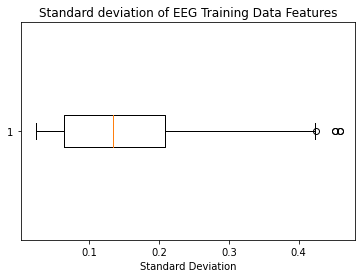

In [ ]:
# Visualize standard deviation data with a box plot
# Whiskers (lines connected to the box) can extend up to 1.5 the length of the inner quartile (box), up to the last data point within that range
plt.boxplot(emot_std_train,vert = False)
plt.title('Standard deviation of EEG Training Data Features')
plt.xlabel('Standard Deviation')
plt.show()

In [ ]:

# Extract columns with a std dev above 75% while excluding outliers (data points past the upper quartile whisker)
extracted_std_train = emot_std_train.loc[((emot_std_train >= emot_stats[6]) & (emot_std_train <= (emot_stats[6] + emot_IQR)))]
# Emotion Pos/Neg/Ntrl labels for each row of the training data -- separated due to being a string and thus not included in the standard deviation output
extracted_emot_labels = emot_norm_train.iloc[0:1900,-1]
# Get the normalized data for the columns of interest and then reattach the emotion labels
extracted_filtered = emot_norm_train[extracted_std_train.index]
extracted_filtered = pd.concat([extracted_filtered,extracted_emot_labels],axis = 1)

# Split the data by emotion label into three sets of data
emotePosNorm = extracted_filtered.loc[extracted_filtered[emot_columns[-1]] == 'POSITIVE']
emoteNegNorm = extracted_filtered.loc[extracted_filtered[emot_columns[-1]] == 'NEGATIVE']
emoteNtrlNorm = extracted_filtered.loc[extracted_filtered[emot_columns[-1]] == 'NEUTRAL']

# Get the standard deviation for each column in each set of data
emotePosNorm_std = emotePosNorm.std()
emoteNegNorm_std = emoteNegNorm.std()
emoteNtrlNorm_std = emoteNtrlNorm.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


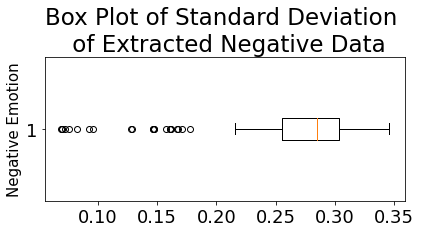

In [ ]:
# Box plots separated by emotion type

fig = plt.figure(1,(6,8))

#plt.subplot(311)
#plt.boxplot(emotePosNorm_std, vert = False)
#plt.title('Standard Deviation of Extracted Positive Data')

plt.subplot(312)
plt.boxplot(emoteNegNorm_std, vert = False)
plt.title('Box Plot of Standard Deviation \n of Extracted Negative Data', FontSize= 23)
plt.ylabel('Negative Emotion', FontSize= 15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

#plt.subplot(313)
#plt.boxplot(emoteNtrlNorm_std, vert = False)
#plt.title('Standard Deviation of Extracted Neutral Data',)
plt.tight_layout()
plt.show()

In [ ]:
# Obtain inner quartile values from the box plots
pos_stats = df.describe(emotePosNorm_std)
neg_stats = df.describe(emoteNegNorm_std)
ntrl_stats = df.describe(emoteNtrlNorm_std)

# Inner quartile (IQR) for each set of emotion data
IQR_pos = emotePosNorm_std.loc[((emotePosNorm_std <= pos_stats[6]) & (emotePosNorm_std >= pos_stats[4]))]
IQR_neg = emoteNegNorm_std.loc[((emoteNegNorm_std <= neg_stats[6]) & (emoteNegNorm_std >= neg_stats[4]))]
IQR_ntrl = emoteNtrlNorm_std.loc[((emoteNtrlNorm_std <= ntrl_stats[6]) & (emoteNtrlNorm_std >= ntrl_stats[4]))]

# Empty list to store column labels that, upon comparison, appear in the positive and negative sets
cmpr1 = []
# Identify the columns that positive and negative emotions IQRs have in common
for i in range(len(IQR_pos)):
    for j in range(len(IQR_neg)):
        if IQR_pos.index[i] == IQR_neg.index[j]:
            cmpr1.append(IQR_neg.index[j])
            break
# Compares the first list against the neutral index labels
cmpr2 = []
# Check neutral emotion set to identify columns that appear in all three, individual IQRs
for i in range(len(IQR_ntrl)):
    for j in range(len(cmpr1)):
        if IQR_ntrl.index[i] == cmpr1[j]:
            cmpr2.append(IQR_ntrl.index[i])
            break
# Attach the column label for emotions to the filtered set of columns
cmpr2.append(extracted_filtered.columns[-1])
# Create the filtered, non-normalized data set that contains the columns needing to train a neural network
emot_filtered_data = emot_data[cmpr2]
print((emot_filtered_data))

      fft_36_a  fft_39_a  fft_56_a  fft_59_a  fft_71_a  fft_74_a  fft_85_a  \
0       -75.10    -75.10     365.0     365.0   323.000   323.000    -512.0   
1        22.80     22.80     -10.8     -10.8    20.400    20.400     167.0   
2       432.00    432.00     369.0     369.0   343.000   343.000    -358.0   
3       508.00    508.00      93.0      93.0   -48.900   -48.900     269.0   
4        21.20     21.20     -37.6     -37.6    20.700    20.700     160.0   
...        ...       ...       ...       ...       ...       ...       ...   
2127     -7.86     -7.86     -10.1     -10.1    -6.020    -6.020     143.0   
2128    517.00    517.00     231.0     231.0   348.000   348.000    -173.0   
2129    299.00    299.00     -94.6     -94.6  -113.000  -113.000      37.8   
2130    323.00    323.00     580.0     580.0   631.000   631.000    -635.0   
2131     13.60     13.60      16.8      16.8    -0.411    -0.411     171.0   

      fft_100_a  fft_125_a  fft_231_a  ...  fft_644_b  fft_656_

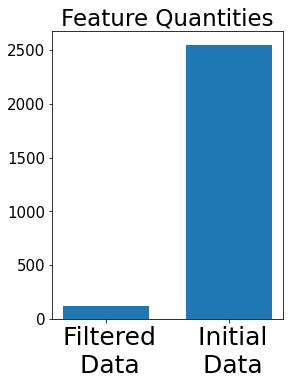

In [ ]:
# Bar graph to demonstrate the difference between raw and filtered feature (column) quantity

fig = plt.figure(figsize = (8,5))
data_quantity = [emot_filtered_data.shape[1] - 1,emot_data.shape[1] - 1]
axis_names = ['  Filtered \n Data','  Initial \n Data']
ax = fig.add_axes([0,0,0.4,0.8])
ax.bar(axis_names, data_quantity, 0.7)
ax.set_title('Feature Quantities', Fontsize = 23)
plt.xticks(fontsize=25)
plt.yticks(fontsize=15)
plt.show()

## RNN Model Definition

In [ ]:
# Convert Pandas data to a numpy array
emot_filtered_std_np = emot_filtered_data.to_numpy()
emot_filtered_norm_np = emot_norm[emot_filtered_data.columns].to_numpy()
print(emot_filtered_std_np.shape)


(2132, 119)


In [ ]:
# Use np.where to create target output data used during training

emot_targets = np.zeros(len(emot_filtered_std_np))
emot_pos_index = np.where(emot_filtered_std_np[:,-1]=="POSITIVE")
emot_neg_index = np.where(emot_filtered_std_np[:,-1]=="NEGATIVE")
emot_neutral_index = np.where(emot_filtered_std_np[:,-1]=="NEUTRAL")

# Translates identifying string labels into a number the model can use
emot_targets[emot_pos_index] = 0 
emot_targets[emot_neg_index] = 1
emot_targets[emot_neutral_index] = 2

print(emot_targets.shape)

(2132,)


In [ ]:
emot_training = emot_filtered_norm_np[:1900,:-1].astype('float')
emot_training_fc = emot_training.copy()
emot_testing = emot_filtered_norm_np[1900:,:-1].astype('float')

emot_training_target = emot_targets[:1900].astype('long')
emot_testing_target = emot_targets[1900:].astype('long')
seq_len = emot_training.shape[1]


In [ ]:
class Emotion_RNN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, sequence_length):
        
        super(Emotion_RNN, self).__init__()
        
        # Using GRU cell with batch_first = True, i.e., we are using (sample_size, sequence_length, # of features) format
        # Bidirectional = True, both foward and backward context 
        self.gru = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                                num_layers = num_layers, 
                                batch_first = True,
                                bidirectional = True,
                                dropout = 0.15)
        # Decoder layer to take in GRU hidden states and output numbers equal to the output_size, which is used to estimate the probable emotional state
        
        self.decoder = torch.nn.Linear(hidden_size*2*sequence_length, output_size) 
        
    def forward(self, input_seq, hidden_state):
        
        # Feed gru cell with input sequence and initial hidden state
        emotion_pred, hidden = self.gru(input_seq, hidden_state)
        # Flatten the dimensions of minibatch, to avoid passing each hidden state along an extra dimension
        emotion_pred = emotion_pred.reshape(len(emotion_pred),-1)

        # Feed the output of the GRU (emotion_pred) to decoder layer
        emotion_pred_out = self.decoder(emotion_pred)

        return emotion_pred_out

## Define Hyperparameters for RNN Model

In [ ]:
# Define the model
emotion_rnn = Emotion_RNN(input_size = 1, hidden_size = 32, 
                            num_layers = 3, output_size = 3, sequence_length = seq_len)

# Learning rate and number of epochs
learning_rate = 0.001   
epochs = 35

# Mini-batch size
batchsize = 50

# Loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(emotion_rnn.parameters(), lr=learning_rate)

# Print out model specifics, add .cuda() if using GPU
emotion_rnn #.cuda()

Emotion_RNN(
  (gru): GRU(1, 32, num_layers=3, batch_first=True, dropout=0.15, bidirectional=True)
  (decoder): Linear(in_features=7552, out_features=3, bias=True)
)


## Identify Tracked Values


In [ ]:
# Empty list to keep track of training loss

train_loss_list = []
correct_valid = []

## Train RNN Model

In [ ]:
# Reshape to match Number of Samples, Sequence Length, Number of Features

emot_training = emot_training.reshape(-1,len(emot_training[0]),1)
emot_testing = emot_testing.reshape(-1,len(emot_testing[0]),1)

print(emot_training.shape)

(1900, 118, 1)


In [ ]:
# Create a subset of the training data for validation
emot_training2 = emot_training[0:-150]
emot_validate_rnn = emot_training[-150:]
emot_training_target2 = emot_training_target[0:-150]
emot_validate_target = emot_training_target[-150:]

# Converts training data into torch tensors
train_input_seqs = torch.from_numpy(emot_training2).float()
train_output_seqs = torch.from_numpy(emot_training_target2).long()

valid_input_seqs_rnn = torch.from_numpy(emot_validate_rnn).float()
valid_output_seqs_rnn = torch.from_numpy(emot_validate_target).long()

# Splits the training data into mini-batches
train_batches_features = torch.split(train_input_seqs, batchsize)
train_batches_targets = torch.split(train_output_seqs, batchsize)

# Total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

for epoch in range(epochs):
    
    for k in range(batch_split_num):

        # initialize the hidden states as None
        hidden_state = None
    
        # Feed in k-th mini-batch training features to neural network
        emotion_predict = emotion_rnn(train_batches_features[k], hidden_state)

        # zero_grad() to clear gradient buffer
        optimizer.zero_grad()
        
        # Compute loss between the model's output and the target training sequence
        loss = loss_func(emotion_predict, train_batches_targets[k])
        # Append loss to loss list
        train_loss_list.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update weights/biases
        optimizer.step()

    # Print the averaged training loss throughout each epoch
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))
    with torch.no_grad():
      validate_out_rnn = emotion_rnn(valid_input_seqs_rnn,None)
      correct_valid = (torch.argmax(validate_out_rnn, dim = 1) == 
                 valid_output_seqs_rnn).type(torch.FloatTensor)
      print('Validation accuracy for epoch',epoch, ': {:.3f}'.format((float)(correct_valid.mean())))


Averaged Training Loss for Epoch  0 :  0.9213652082851955
Validation accuracy for epoch 0 : 0.553
Averaged Training Loss for Epoch  1 :  0.7683359129088265
Validation accuracy for epoch 1 : 0.673
Averaged Training Loss for Epoch  2 :  0.7159414257322039
Validation accuracy for epoch 2 : 0.793
Averaged Training Loss for Epoch  3 :  0.6709514030388424
Validation accuracy for epoch 3 : 0.800
Averaged Training Loss for Epoch  4 :  0.5520209363528661
Validation accuracy for epoch 4 : 0.833
Averaged Training Loss for Epoch  5 :  0.5010827396597181
Validation accuracy for epoch 5 : 0.847
Averaged Training Loss for Epoch  6 :  0.40943773814610074
Validation accuracy for epoch 6 : 0.847
Averaged Training Loss for Epoch  7 :  0.38047635555267334
Validation accuracy for epoch 7 : 0.847
Averaged Training Loss for Epoch  8 :  0.30597912115710124
Validation accuracy for epoch 8 : 0.860
Averaged Training Loss for Epoch  9 :  0.32778553153787343
Validation accuracy for epoch 9 : 0.887
Averaged Trainin

## Visualize & Evaluate RNN Model

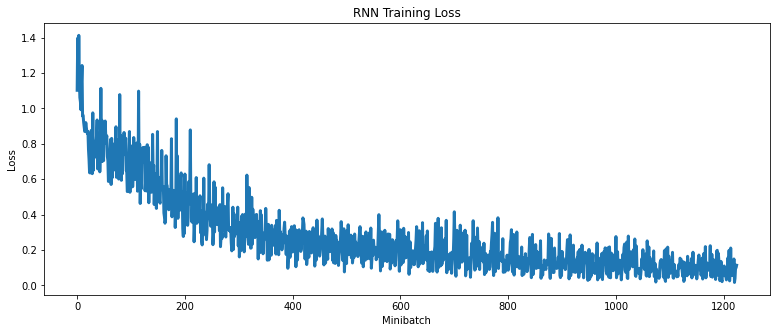

In [ ]:
# Training loss across epochs
plt.figure(figsize = (13, 5))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.title('RNN Training Loss')
plt.show()

In [ ]:
# Convert testing data to a torch tensor
test_input_seqs = torch.from_numpy(emot_testing).float()
test_output_seqs = torch.from_numpy(emot_testing_target).long()

# Empty lists to keep track of RNN denoised test sequences and test losses
test_prediction = []
test_losses = []

# Turn on no_grad() since we aren't performing backprop during this process
with torch.no_grad():
    
    test_pred = emotion_rnn(test_input_seqs, None)
    # Compare the test_pred with test target sequence to compute testing loss

    test_loss = loss_func(test_pred, test_output_seqs)
        
    test_losses.append(test_loss.item())
        
# Final testing loss is the average of all the test_losses from mini-batches        
print("Testing Loss (Least Absolute Deviations): ", np.mean(test_losses))

Testing Loss (Least Absolute Deviations):  0.33989399671554565


In [ ]:
# Testing Accuracy

test_accuracy_list = []
correct_test = (torch.argmax(test_pred, dim = 1) == test_output_seqs).type(torch.FloatTensor)
# Argmax is used to identify the predicted output, which is compared against the target value representing a particular emotion
test_accuracy_list.append(correct_test.mean())
print('Testing accuracy: {:.3f}'.format((float)(test_accuracy_list[0])))

Testing accuracy: 0.897


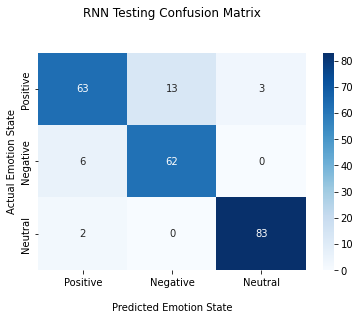

In [ ]:
cf_matrix = confusion_matrix(torch.argmax(test_pred, dim = 1),test_output_seqs)


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('RNN Testing Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion State')
ax.set_ylabel('Actual Emotion State');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative', 'Neutral'])
ax.yaxis.set_ticklabels(['Positive','Negative', 'Neutral'])

## Display the visualization of the Confusion Matrix.
plt.show()


## Define Fully Connected Model (Using Filtered Features)

In [ ]:
class Emotion_FC(torch.nn.Module):
  # Inputs:
        # input_dim:   Dimension of input data to be fed into the model
        # hidden_dim1: Dimension of first hidden layer, corresponding to its output after processing input_dim data
        # hidden_dim2: Dimension of the second hidden layer, processing inputs from hidden_dim1
        # output_dim:  Dimension of final output after data from hidden_dim2 has been processed
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Emotion_FC, self).__init__()

        self.layer1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.layer2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = torch.nn.Linear(hidden_dim2, output_dim)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim1)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_dim2)

    def forward(self, x):
        
        # Normalizes before passing through a ReLU activation function
        out1 = self.layer1(x)
        out1 = self.batch_norm1(out1)
        out1 = torch.nn.functional.relu(out1)
        
        out2 = self.layer2(out1)
        out2 = self.batch_norm2(out2)
        out2 = torch.nn.functional.relu(out2)
        
        out = self.layer3(out2)
        
        return out



## Define Hyperparameters for Fully Connected Model (Filtered)

In [ ]:
# Define a fully connected neural network
emotion_fc = Emotion_FC(emot_training.shape[1],2450,750,3)

# Learning rate and epoch 
learning_rate = 0.00021 
epochs = 90

# Loss function and optimizer
loss_func_fc = torch.nn.CrossEntropyLoss()
optimizer_fc = torch.optim.Adam(emotion_fc.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    emotion_fc.cuda()

emotion_fc


Emotion_FC(
  (layer1): Linear(in_features=118, out_features=2450, bias=True)
  (layer2): Linear(in_features=2450, out_features=750, bias=True)
  (layer3): Linear(in_features=750, out_features=3, bias=True)
  (batch_norm1): BatchNorm1d(2450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Train Fully Connected Model (Filtered)

In [ ]:
import tqdm

# Convert input data and output targets to torch tensors
emot_training_fc2 = emot_training_fc[0:-150]
emot_validate_fc = emot_training_fc[-150:]
emot_training_target2 = emot_training_target[0:-150]
emot_validate_target = emot_training_target[-150:]

train_input_seqs_fc = torch.from_numpy(emot_training_fc2).float()
train_input_seqs_fc = train_input_seqs_fc.reshape(train_input_seqs_fc.shape[0],-1).float()
valid_input_seqs_fc = torch.from_numpy(emot_validate_fc).float()
valid_input_seqs_fc = valid_input_seqs_fc.reshape(valid_input_seqs_fc.shape[0],-1).float()

train_output_seqs_fc = torch.from_numpy(emot_training_target2).long()
valid_output_seqs_fc = torch.from_numpy(emot_validate_target).long()

train_loss_list = []
train_accuracy_list = []
correct_valid = []

# Train the fully connected model
for epoch in tqdm.trange(epochs):
    
    optimizer_fc.zero_grad() # Reset the gradient for each learning attempt
    training_outputs = emotion_fc(train_input_seqs_fc)
    
    loss = loss_func_fc(training_outputs,train_output_seqs_fc) # Checks the model against expected results
    train_loss_list.append(loss.item())

#    correct = training_outputs/train_output_seqs_fc[epoch]
#    train_accuracy_list.append(correct.item())
    loss.backward()
    optimizer_fc.step() # Update model weights

    with torch.no_grad():
      validate_out_fc = emotion_fc(valid_input_seqs_fc)
      correct_valid = (torch.argmax(validate_out_fc, dim = 1) == 
                 valid_output_seqs_fc).type(torch.FloatTensor)
      print('Validation accuracy for epoch',epoch, ': {:.3f}'.format((float)(correct_valid.mean())))


  1%|          | 1/90 [00:00<00:53,  1.65it/s]

Validation accuracy for epoch 0 : 0.680


  2%|▏         | 2/90 [00:01<00:46,  1.91it/s]

Validation accuracy for epoch 1 : 0.707


  3%|▎         | 3/90 [00:01<00:43,  2.00it/s]

Validation accuracy for epoch 2 : 0.773


  4%|▍         | 4/90 [00:01<00:41,  2.08it/s]

Validation accuracy for epoch 3 : 0.827


  6%|▌         | 5/90 [00:02<00:40,  2.11it/s]

Validation accuracy for epoch 4 : 0.840


  7%|▋         | 6/90 [00:02<00:39,  2.12it/s]

Validation accuracy for epoch 5 : 0.880


  8%|▊         | 7/90 [00:03<00:38,  2.15it/s]

Validation accuracy for epoch 6 : 0.913


  9%|▉         | 8/90 [00:03<00:38,  2.14it/s]

Validation accuracy for epoch 7 : 0.887


 10%|█         | 9/90 [00:04<00:37,  2.16it/s]

Validation accuracy for epoch 8 : 0.880


 11%|█         | 10/90 [00:04<00:36,  2.19it/s]

Validation accuracy for epoch 9 : 0.880


 12%|█▏        | 11/90 [00:05<00:35,  2.21it/s]

Validation accuracy for epoch 10 : 0.880


 13%|█▎        | 12/90 [00:05<00:35,  2.21it/s]

Validation accuracy for epoch 11 : 0.880


 14%|█▍        | 13/90 [00:06<00:34,  2.21it/s]

Validation accuracy for epoch 12 : 0.873


 16%|█▌        | 14/90 [00:06<00:34,  2.20it/s]

Validation accuracy for epoch 13 : 0.887


 17%|█▋        | 15/90 [00:07<00:34,  2.19it/s]

Validation accuracy for epoch 14 : 0.887


 18%|█▊        | 16/90 [00:07<00:33,  2.20it/s]

Validation accuracy for epoch 15 : 0.893


 19%|█▉        | 17/90 [00:07<00:32,  2.22it/s]

Validation accuracy for epoch 16 : 0.893


 20%|██        | 18/90 [00:08<00:32,  2.21it/s]

Validation accuracy for epoch 17 : 0.893


 21%|██        | 19/90 [00:08<00:32,  2.21it/s]

Validation accuracy for epoch 18 : 0.893


 22%|██▏       | 20/90 [00:09<00:31,  2.21it/s]

Validation accuracy for epoch 19 : 0.893


 23%|██▎       | 21/90 [00:09<00:31,  2.21it/s]

Validation accuracy for epoch 20 : 0.900


 24%|██▍       | 22/90 [00:10<00:30,  2.22it/s]

Validation accuracy for epoch 21 : 0.900


 26%|██▌       | 23/90 [00:10<00:30,  2.20it/s]

Validation accuracy for epoch 22 : 0.900


 27%|██▋       | 24/90 [00:11<00:30,  2.19it/s]

Validation accuracy for epoch 23 : 0.913


 28%|██▊       | 25/90 [00:11<00:29,  2.17it/s]

Validation accuracy for epoch 24 : 0.920


 29%|██▉       | 26/90 [00:12<00:29,  2.18it/s]

Validation accuracy for epoch 25 : 0.920


 30%|███       | 27/90 [00:12<00:28,  2.18it/s]

Validation accuracy for epoch 26 : 0.920


 31%|███       | 28/90 [00:12<00:28,  2.18it/s]

Validation accuracy for epoch 27 : 0.920


 32%|███▏      | 29/90 [00:13<00:28,  2.16it/s]

Validation accuracy for epoch 28 : 0.920


 33%|███▎      | 30/90 [00:13<00:28,  2.13it/s]

Validation accuracy for epoch 29 : 0.920


 34%|███▍      | 31/90 [00:14<00:27,  2.11it/s]

Validation accuracy for epoch 30 : 0.920


 36%|███▌      | 32/90 [00:14<00:26,  2.15it/s]

Validation accuracy for epoch 31 : 0.920


 37%|███▋      | 33/90 [00:15<00:26,  2.13it/s]

Validation accuracy for epoch 32 : 0.927


 38%|███▊      | 34/90 [00:15<00:26,  2.13it/s]

Validation accuracy for epoch 33 : 0.927


 39%|███▉      | 35/90 [00:16<00:25,  2.13it/s]

Validation accuracy for epoch 34 : 0.927


 40%|████      | 36/90 [00:16<00:25,  2.16it/s]

Validation accuracy for epoch 35 : 0.927


 41%|████      | 37/90 [00:17<00:24,  2.17it/s]

Validation accuracy for epoch 36 : 0.927


 42%|████▏     | 38/90 [00:17<00:23,  2.19it/s]

Validation accuracy for epoch 37 : 0.927


 43%|████▎     | 39/90 [00:18<00:23,  2.21it/s]

Validation accuracy for epoch 38 : 0.933


 44%|████▍     | 40/90 [00:18<00:23,  2.16it/s]

Validation accuracy for epoch 39 : 0.933


 46%|████▌     | 41/90 [00:18<00:22,  2.15it/s]

Validation accuracy for epoch 40 : 0.933


 47%|████▋     | 42/90 [00:19<00:22,  2.16it/s]

Validation accuracy for epoch 41 : 0.940


 48%|████▊     | 43/90 [00:19<00:21,  2.19it/s]

Validation accuracy for epoch 42 : 0.933


 49%|████▉     | 44/90 [00:20<00:21,  2.15it/s]

Validation accuracy for epoch 43 : 0.933


 50%|█████     | 45/90 [00:20<00:20,  2.16it/s]

Validation accuracy for epoch 44 : 0.927


 51%|█████     | 46/90 [00:21<00:20,  2.15it/s]

Validation accuracy for epoch 45 : 0.940


 52%|█████▏    | 47/90 [00:21<00:19,  2.18it/s]

Validation accuracy for epoch 46 : 0.940


 53%|█████▎    | 48/90 [00:22<00:19,  2.20it/s]

Validation accuracy for epoch 47 : 0.940


 54%|█████▍    | 49/90 [00:22<00:18,  2.20it/s]

Validation accuracy for epoch 48 : 0.940


 56%|█████▌    | 50/90 [00:23<00:18,  2.19it/s]

Validation accuracy for epoch 49 : 0.940


 57%|█████▋    | 51/90 [00:23<00:18,  2.17it/s]

Validation accuracy for epoch 50 : 0.940


 58%|█████▊    | 52/90 [00:24<00:17,  2.20it/s]

Validation accuracy for epoch 51 : 0.940


 59%|█████▉    | 53/90 [00:24<00:16,  2.20it/s]

Validation accuracy for epoch 52 : 0.940


 60%|██████    | 54/90 [00:24<00:16,  2.23it/s]

Validation accuracy for epoch 53 : 0.940


 61%|██████    | 55/90 [00:25<00:15,  2.22it/s]

Validation accuracy for epoch 54 : 0.940


 62%|██████▏   | 56/90 [00:25<00:15,  2.22it/s]

Validation accuracy for epoch 55 : 0.940


 63%|██████▎   | 57/90 [00:26<00:14,  2.21it/s]

Validation accuracy for epoch 56 : 0.940


 64%|██████▍   | 58/90 [00:26<00:14,  2.21it/s]

Validation accuracy for epoch 57 : 0.940


 66%|██████▌   | 59/90 [00:27<00:14,  2.19it/s]

Validation accuracy for epoch 58 : 0.940


 67%|██████▋   | 60/90 [00:27<00:13,  2.17it/s]

Validation accuracy for epoch 59 : 0.940


 68%|██████▊   | 61/90 [00:28<00:13,  2.19it/s]

Validation accuracy for epoch 60 : 0.933


 69%|██████▉   | 62/90 [00:28<00:12,  2.20it/s]

Validation accuracy for epoch 61 : 0.933


 70%|███████   | 63/90 [00:29<00:12,  2.22it/s]

Validation accuracy for epoch 62 : 0.933


 71%|███████   | 64/90 [00:29<00:11,  2.18it/s]

Validation accuracy for epoch 63 : 0.933


 72%|███████▏  | 65/90 [00:29<00:11,  2.20it/s]

Validation accuracy for epoch 64 : 0.933


 73%|███████▎  | 66/90 [00:30<00:10,  2.20it/s]

Validation accuracy for epoch 65 : 0.933


 74%|███████▍  | 67/90 [00:30<00:10,  2.21it/s]

Validation accuracy for epoch 66 : 0.933


 76%|███████▌  | 68/90 [00:31<00:09,  2.22it/s]

Validation accuracy for epoch 67 : 0.933


 77%|███████▋  | 69/90 [00:31<00:09,  2.21it/s]

Validation accuracy for epoch 68 : 0.933


 78%|███████▊  | 70/90 [00:32<00:09,  2.20it/s]

Validation accuracy for epoch 69 : 0.933


 79%|███████▉  | 71/90 [00:32<00:08,  2.17it/s]

Validation accuracy for epoch 70 : 0.933


 80%|████████  | 72/90 [00:33<00:08,  2.17it/s]

Validation accuracy for epoch 71 : 0.933


 81%|████████  | 73/90 [00:33<00:07,  2.13it/s]

Validation accuracy for epoch 72 : 0.933


 82%|████████▏ | 74/90 [00:34<00:07,  2.17it/s]

Validation accuracy for epoch 73 : 0.933


 83%|████████▎ | 75/90 [00:34<00:06,  2.18it/s]

Validation accuracy for epoch 74 : 0.933


 84%|████████▍ | 76/90 [00:34<00:06,  2.20it/s]

Validation accuracy for epoch 75 : 0.933


 86%|████████▌ | 77/90 [00:35<00:05,  2.19it/s]

Validation accuracy for epoch 76 : 0.933


 87%|████████▋ | 78/90 [00:35<00:05,  2.16it/s]

Validation accuracy for epoch 77 : 0.933


 88%|████████▊ | 79/90 [00:36<00:05,  2.17it/s]

Validation accuracy for epoch 78 : 0.933


 89%|████████▉ | 80/90 [00:36<00:04,  2.18it/s]

Validation accuracy for epoch 79 : 0.933


 90%|█████████ | 81/90 [00:37<00:04,  2.17it/s]

Validation accuracy for epoch 80 : 0.933


 91%|█████████ | 82/90 [00:37<00:03,  2.16it/s]

Validation accuracy for epoch 81 : 0.933


 92%|█████████▏| 83/90 [00:38<00:03,  2.16it/s]

Validation accuracy for epoch 82 : 0.933


 93%|█████████▎| 84/90 [00:38<00:02,  2.13it/s]

Validation accuracy for epoch 83 : 0.933


 94%|█████████▍| 85/90 [00:39<00:02,  2.15it/s]

Validation accuracy for epoch 84 : 0.933


 96%|█████████▌| 86/90 [00:39<00:01,  2.14it/s]

Validation accuracy for epoch 85 : 0.933


 97%|█████████▋| 87/90 [00:40<00:01,  2.17it/s]

Validation accuracy for epoch 86 : 0.933


 98%|█████████▊| 88/90 [00:40<00:00,  2.20it/s]

Validation accuracy for epoch 87 : 0.933


 99%|█████████▉| 89/90 [00:40<00:00,  2.21it/s]

Validation accuracy for epoch 88 : 0.933


100%|██████████| 90/90 [00:41<00:00,  2.17it/s]

Validation accuracy for epoch 89 : 0.933


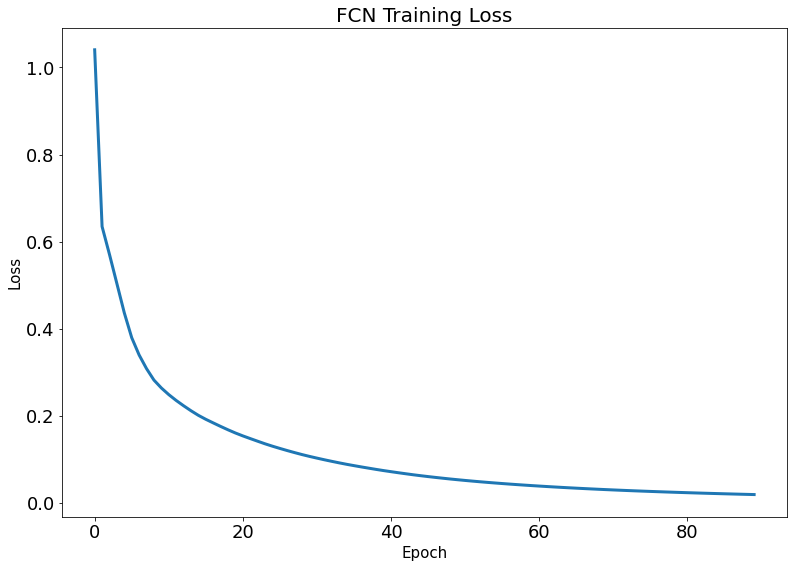

In [ ]:
plt.figure(figsize = (13, 9))


plt.plot(train_loss_list, linewidth = 3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Epoch',Fontsize=15)
plt.ylabel('Loss',Fontsize= 15)
plt.title('FCN Training Loss',Fontsize= 20)
plt.show()

## Visualize & Evaluate Fully Connected Model (Filtered)

In [ ]:
# Tests the model's accuracy with data set aside for testing purposes
emot_testing_fc = emot_filtered_norm_np[1900:,:-1].astype('float')

test_input_seqs_fc = torch.from_numpy(emot_testing_fc).float()
test_output_seqs_fc = torch.from_numpy(emot_testing_target).long()

test_accuracy_list = []
correct_test = []
test_accur = []
test_out = emotion_fc(test_input_seqs_fc)
correct_test = (torch.argmax(test_out, dim = 1) == 
                 test_output_seqs_fc).type(torch.FloatTensor)
# Finds accuracy based on 1 representing the model predicting correctly and 0 being an inaccurate prediction
print('Testing accuracy: {:.3f}'.format((float)(correct_test.mean())))


Testing accuracy: 0.922


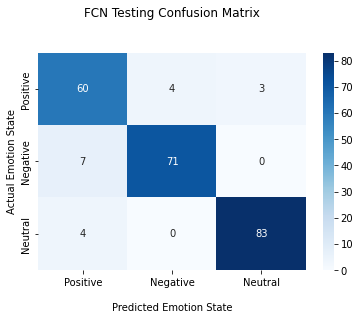

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(torch.argmax(test_out, dim = 1),test_output_seqs_fc)


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('FCN Testing Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion State')
ax.set_ylabel('Actual Emotion State');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative', 'Neutral'])
ax.yaxis.set_ticklabels(['Positive','Negative', 'Neutral'])

## Display the visualization of the Confusion Matrix.
plt.show()




## Define Fully Connected Model (Using Unfiltered Features)

In [ ]:
class Emotion_UFC(torch.nn.Module):
  # Inputs:
        # input_dim:   Dimension of input data to be fed into the model
        # hidden_dim1: Dimension of first hidden layer, corresponding to its output after processing input_dim data
        # hidden_dim2: Dimension of the second hidden layer, processing inputs from hidden_dim1
        # output_dim:  Dimension of final output after data from hidden_dim2 has been processed
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Emotion_UFC, self).__init__()

        self.layer1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.layer2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.layer4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.layer5 = torch.nn.Linear(hidden_dim4, output_dim)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim1)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_dim2)
        self.batch_norm3 = torch.nn.BatchNorm1d(hidden_dim3)
        self.batch_norm4 = torch.nn.BatchNorm1d(hidden_dim4)

    def forward(self, x):
        
        # Normalizes before passing through a ReLU activation function
        out1 = self.layer1(x)
        out1 = self.batch_norm1(out1)
        out1 = torch.nn.functional.relu(out1)
        
        out2 = self.layer2(out1)
        out2 = self.batch_norm2(out2)
        out2 = torch.nn.functional.relu(out2)

        out3 = self.layer3(out2)
        out3 = self.batch_norm3(out3)
        out3 = torch.nn.functional.relu(out3)

        out4 = self.layer4(out3)
        out4 = self.batch_norm4(out4)
        out4 = torch.nn.functional.relu(out4)
                
        
        out = self.layer5(out4)
        
        return out

## Define Hyperparameters for Fully Connected Model (Unfiltered)

In [ ]:
emot_testing_ufc = emot_norm_test.to_numpy()
emot_testing_ufc = emot_testing_ufc[:,:-1].astype('float')
emot_training_ufc = emot_norm[0:1900].to_numpy()
emot_training_ufc = emot_training_ufc[:,:-1].astype('float')
print(np.shape(emot_training_ufc))

# Define a fully connected neural network
emotion_ufc = Emotion_UFC(emot_training_ufc.shape[1],5000,3000,750,300,3)

# Learning rate and epoch 
learning_rate = 0.00021 
epochs = 30

# Loss function and optimizer
loss_func_ufc = torch.nn.CrossEntropyLoss()
optimizer_ufc = torch.optim.Adam(emotion_ufc.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    emotion_ufc.cuda()

emotion_ufc


(1900, 2548)


Emotion_UFC(
  (layer1): Linear(in_features=2548, out_features=5000, bias=True)
  (layer2): Linear(in_features=5000, out_features=3000, bias=True)
  (layer3): Linear(in_features=3000, out_features=750, bias=True)
  (layer4): Linear(in_features=750, out_features=300, bias=True)
  (layer5): Linear(in_features=300, out_features=3, bias=True)
  (batch_norm1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Train Fully Connected Model (Unfiltered)

In [ ]:
import tqdm

# Convert input data and output targets to torch tensors
emot_training_ufc2 = emot_training_ufc[0:-150]
emot_validate_ufc = emot_training_ufc[-150:]
emot_training_target2 = emot_training_target[0:-150]
emot_validate_target = emot_training_target[-150:]


train_input_seqs_ufc = torch.from_numpy(emot_training_ufc2).float()
train_input_seqs_ufc = train_input_seqs_ufc.reshape(train_input_seqs_ufc.shape[0],-1).float()
valid_input_seqs_ufc = torch.from_numpy(emot_validate_ufc).float()
valid_input_seqs_ufc = valid_input_seqs_ufc.reshape(valid_input_seqs_ufc.shape[0],-1).float()


train_output_seqs_ufc = torch.from_numpy(emot_training_target2).long()
valid_output_seqs_ufc = torch.from_numpy(emot_validate_target).long()

train_loss_list = []
correct_valid = []


# Train the fully connected model
for epoch in tqdm.trange(epochs):
    
    optimizer_ufc.zero_grad() # Reset the gradient for each learning attempt
    training_outputs = emotion_ufc(train_input_seqs_ufc)
    
    loss = loss_func_ufc(training_outputs,train_output_seqs_ufc) # Checks the model against expected results
    train_loss_list.append(loss.item())
    loss.backward()
    optimizer_ufc.step() # Update model weights

    with torch.no_grad():
      validate_out_ufc = emotion_ufc(valid_input_seqs_ufc)
      correct_valid = (torch.argmax(validate_out_ufc, dim = 1) == 
                 valid_output_seqs_ufc).type(torch.FloatTensor)
      print('Validation accuracy for epoch',epoch, ': {:.3f}'.format((float)(correct_valid.mean())))

  3%|▎         | 1/30 [00:07<03:49,  7.92s/it]

Validation accuracy for epoch 0 : 0.900


  7%|▋         | 2/30 [00:12<02:49,  6.07s/it]

Validation accuracy for epoch 1 : 0.927


 10%|█         | 3/30 [00:17<02:32,  5.64s/it]

Validation accuracy for epoch 2 : 0.933


 13%|█▎        | 4/30 [00:23<02:30,  5.77s/it]

Validation accuracy for epoch 3 : 0.927


 17%|█▋        | 5/30 [00:28<02:18,  5.55s/it]

Validation accuracy for epoch 4 : 0.940


 20%|██        | 6/30 [00:34<02:13,  5.55s/it]

Validation accuracy for epoch 5 : 0.947


 23%|██▎       | 7/30 [00:39<02:01,  5.27s/it]

Validation accuracy for epoch 6 : 0.953


 27%|██▋       | 8/30 [00:43<01:51,  5.09s/it]

Validation accuracy for epoch 7 : 0.967


 30%|███       | 9/30 [00:48<01:44,  4.97s/it]

Validation accuracy for epoch 8 : 0.967


 33%|███▎      | 10/30 [00:53<01:38,  4.92s/it]

Validation accuracy for epoch 9 : 0.967


 37%|███▋      | 11/30 [00:58<01:32,  4.88s/it]

Validation accuracy for epoch 10 : 0.960


 40%|████      | 12/30 [01:02<01:27,  4.84s/it]

Validation accuracy for epoch 11 : 0.960


 43%|████▎     | 13/30 [01:07<01:22,  4.83s/it]

Validation accuracy for epoch 12 : 0.960


 47%|████▋     | 14/30 [01:12<01:16,  4.80s/it]

Validation accuracy for epoch 13 : 0.960


 50%|█████     | 15/30 [01:17<01:11,  4.79s/it]

Validation accuracy for epoch 14 : 0.960


 53%|█████▎    | 16/30 [01:21<01:06,  4.77s/it]

Validation accuracy for epoch 15 : 0.960


 57%|█████▋    | 17/30 [01:26<01:01,  4.76s/it]

Validation accuracy for epoch 16 : 0.960


 60%|██████    | 18/30 [01:32<00:59,  4.93s/it]

Validation accuracy for epoch 17 : 0.960


 63%|██████▎   | 19/30 [01:36<00:53,  4.86s/it]

Validation accuracy for epoch 18 : 0.960


 67%|██████▋   | 20/30 [01:41<00:48,  4.82s/it]

Validation accuracy for epoch 19 : 0.960


 70%|███████   | 21/30 [01:46<00:43,  4.80s/it]

Validation accuracy for epoch 20 : 0.960


 73%|███████▎  | 22/30 [01:50<00:38,  4.78s/it]

Validation accuracy for epoch 21 : 0.960


 77%|███████▋  | 23/30 [01:55<00:33,  4.82s/it]

Validation accuracy for epoch 22 : 0.960


 80%|████████  | 24/30 [02:00<00:28,  4.80s/it]

Validation accuracy for epoch 23 : 0.960


 83%|████████▎ | 25/30 [02:06<00:25,  5.19s/it]

Validation accuracy for epoch 24 : 0.960


 87%|████████▋ | 26/30 [02:11<00:20,  5.06s/it]

Validation accuracy for epoch 25 : 0.960


 90%|█████████ | 27/30 [02:16<00:14,  4.95s/it]

Validation accuracy for epoch 26 : 0.967


 93%|█████████▎| 28/30 [02:20<00:09,  4.88s/it]

Validation accuracy for epoch 27 : 0.967


 97%|█████████▋| 29/30 [02:25<00:04,  4.85s/it]

Validation accuracy for epoch 28 : 0.967


100%|██████████| 30/30 [02:30<00:00,  5.01s/it]

Validation accuracy for epoch 29 : 0.967


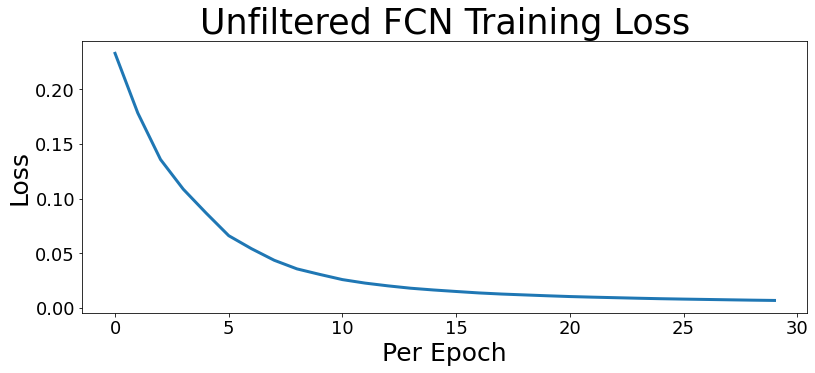

99.9931521397084


In [ ]:
plt.figure(figsize = (13, 5))

plt.plot(train_loss_list, linewidth = 3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Per Epoch',Fontsize=25)
plt.ylabel('Loss',Fontsize= 25)
plt.title('Unfiltered FCN Training Loss',Fontsize= 35)
plt.show()

print(100-train_loss_list[-1])

## Visualize & Evaluate Fully Connected Model *(Unfiltered)*

In [ ]:
#emot_testing_ufc = emot_norm_test.to_numpy()

#emot_testing_ufc = emot_testing_ufc[:,:-1].astype('float')

test_input_seqs_ufc = torch.from_numpy(emot_testing_ufc).float()
test_output_seqs_ufc = torch.from_numpy(emot_testing_target).long()

test_accuracy_list = []
correct_test = []

test_out = emotion_ufc(test_input_seqs_ufc)
correct_test = (torch.argmax(test_out, dim = 1) == 
                 test_output_seqs_ufc).type(torch.FloatTensor)
# Finds accuracy based on 1 representing the model predicting correctly and 0 being an inaccurate prediction
test_accuracy_list.append(correct_test.mean())
print('Testing accuracy: {:.3f}'.format((float)(correct_test.mean())))

Testing accuracy: 0.974


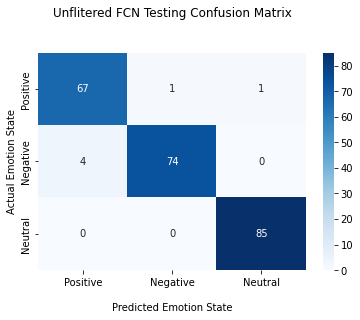

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(torch.argmax(test_out, dim = 1),test_output_seqs_ufc)


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Unflitered FCN Testing Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion State')
ax.set_ylabel('Actual Emotion State');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative', 'Neutral'])
ax.yaxis.set_ticklabels(['Positive','Negative', 'Neutral'])

## Display the visualization of the Confusion Matrix.
plt.show()

